# Deep Learning CA1: Part B

### Name: Law Wei Tin
### Class: DAAA/FT/2A/02
### Admin number: 2415761

<br><hr><br>

## Background Research

The dataset contains 527 relatively short reviews in mostly Malay and English, each paired with a continuous "Score" between 0 and 1. Reviews typically comment on:

<br>

Action and pacing ("thrilling action," "slow first half")

<br>

Character arcs and performances ("satisfying character arcs," "cast chemistry")

<br>

Plot complexity and emotional depth ("complex story full of emotion," "heartfelt farewells")

<br>

Visual effects and production values ("stunning CGI," "spectacular finale")

<br>

This mix of languages and focused commentary on plot, action, and characters gives your sentiment model clear, domain-specific signals—while also motivating the two-stage balancing (language oversampling + class-weighting, because the dataset seems to have more english than other languages, whilst also having more positive reviews than negative) and the choice of classification (Good/Neutral/Bad) to capture the nuances of fan responses.

<br>

**We also notice a few things, such as the more positive reviews tend to have lower scores. This might be due to the scores being inversed. Hence, we will have to look into that later to confirm this.**


<br><hr><br>

## Why Classification (Good/Neutral/Bad) over Regression

Interpretability & Actionability

Grouping reviews into "Good," "Neutral," and "Bad" aligns directly with business needs (e.g., flagging complaints vs. marketing-worthy praise) and is more actionable for content moderation or marketing dashboards than raw numeric scores.

Data Constraints

With only a small subset reviews available, a three-class classification avoids the sparsity pitfalls of learning a continuous regression function over a wide rating scale.

Robustness to Noise

Individual star- or percentage-scores can be noisy or inconsistent across users. Binning into three coarse categories smooths out those idiosyncrasies, letting the model focus on clear positive, negative, or mixed signals in the language itself.

**All in all,** <br>

Classification lets us translate raw review scores into clear, actionable categories—"Good," "Neutral," and "Bad"—that align directly with business needs (e.g. flagging complaints or highlighting praise) and smooth out user-specific rating noise.

<br>

Moreover, although the "Score" field is expressed as a number between 0 and 1, **it isn't a truly continuous, interval-scaled measurement**, it's really just a proxy for three broad sentiment bands. Later on you will see the distribution of the scores, and you will notice this.

<br>

**Treating it as a continuous target in regression would imply that a prediction of 0.412 is meaningfully "twice as negative" as 0.206**, which isn't how human review scores work. With only a few hundred samples, **forcing the model to learn those fine-grained distinctions** risks overfitting to noise and yields predictions that are both hard to interpret and unreliable.

<br>

**By framing the problem as classification into Good/Neutral/Bad, we embrace the categorical nature of sentiment, simplify the learning task, and ensure our outputs are both robust and immediately actionable.**

**Hence our choice of classification.**

<br><hr><br>


# Importing and Installation of Necessary Libraries

## For pip installation:

- **langdetect:** Used for detecting languages, such as English or Malay

- **deep-translator:** Used to translate languages, like from English to Malay for instance.

- **visualkeras:** Used to show model architecture

- **keras-tuner:** Used to hypertune our model



In [ ]:
# pip install langdetect

In [ ]:
# pip install deep-translator

In [ ]:
# pip install visualkeras

In [ ]:
# pip install keras-tuner

In [ ]:
# pip install datasets

In [ ]:
# Common required libraries
import numpy as np
import pandas as pd
import random
from math import ceil, floor
from datasets import Dataset

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

# Torch (only used for checking GPU activeness)
import torch

# Translation library in order to handle multi-languaged reviews
from deep_translator import GoogleTranslator
from langdetect import detect

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

# Used for identifying weird text
import re
import unicodedata

# Word dictionary
from nltk.corpus import wordnet

# Splitting the dataset into train, test
from sklearn.model_selection import train_test_split

# Text preprocessing libraries
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Viewing metrics using confusion matrices and classification reports, or metrics other than accuracy such as precision, recall and f1.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report

# This is for checking text with similarities. This is because we use a T5 paraphraser, a pretrained model to generate more data.
# So, in order to ensure absolute cleanliness, we use Vectorizers and cosine similarity in order to check for similarity.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# How do we determine the thresholds for our classification problem? For example, if a score is below 0.3, is that considered good or bad?
# We use this to plot out a cluster distribution of the scores.
from sklearn.cluster import DBSCAN

# In our code, we only balance the languages. We didn't attempt to balance the sentiments.
# So, in order to handle class imbalances, we use class weights.
from sklearn.utils import class_weight

# Hypertuning
import keras_tuner as kt

# Pretrained models for Data Creation
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Show model architecture
from tensorflow.keras.utils import plot_model

# Ignoring harmless warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Easily upload a file for usage, in this case our movie review csv.
from google.colab import files
uploaded = files.upload()

Saving Movie reviews.csv to Movie reviews.csv


# Exploratory Data Analysis

In [ ]:
df = pd.read_csv("/content/Movie reviews.csv")

## Displaying information about dataset

In [ ]:
# Display information about the raw dataset nicely
pd.set_option('display.max_colwidth', None)
display(df.info())
display(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB


None

,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?"
count,525.000000,0.0
mean,0.282626,NaN
std,0.263022,NaN
min,0.001000,NaN
25%,0.100000,NaN
50%,0.120000,NaN
75%,0.500000,NaN
max,0.997413,NaN


,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persembahan terbaik. Kurang puas hati.",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Sungguh menghiburkan!,0.2,NaN,Malay


From the output above, we can confirm a few things:

<br><hr><br>

Firstly, **the first 3 rows have the same reviews. However, their scores are different.** This is a **grave issue**, as our model might be confused during training. So, we will proceed to ** drop all duplicate reviews** during our Data Preprocessing steps.

<br><hr><br>

Secondly, **translating the reviews** (using google translate manually), we find out that:

- The first review: "Sayang sekali, pelakon tidak memberikan persembahan terbaik. Kurang puas hati." translates to "Too bad the actors didn't give their best performance. Not satisfied." <br> **And we also notice that the respective score is 0.8, even though the review is a negative one.** Let's look at the next one for confirmation.

- The second review: "Jalan cerita yang kompleks dan penuh emosi. Sungguh menghiburkan!" translates to "A complex and emotionally charged storyline. Really entertaining!" <br> **This review's respective rating is 0.2.**

Hence, from this, we can confirm our earlier mention that: <br> **The lower the score, the higher the positivity of the review.**

<br><hr><br>

**Next, we can also observe a column called "Are there ways for you to generate more data? Splitting up sentences, would that help?"**

This column is a nudge towards me to generate more data. Further inspecting the information provided by the output above, we can also observe that there are very little data, about 500 rows, inclusive of duplicates and NaNs. If we were to drop them, we would be left with very little data! So, we will be using methods to generate data during the later data preprocessing part.

We also notice that this column said: "Splitting up sentences, would that help?". My answer is, **No.** <br> You might ask, why? This is because different parts of reviews could tell a different story. For example, let's say an example of a review could be: "I like the plot and action scenes of the movie. **However**, I feel like the main character's acting was bad." If we split the sentences, and give the two rows the same score, it would be wrong, wouldn't it? (Unless we manually score each split sentence, which is highly inefficient, there's no reliable way to preserve the original context or sentiment.) **Therefore, splitting sentences would likely do more harm than good.** We will not be implementing this as a way to generating more data.

<br><hr><br>

## Dropping unnecessary columns

In [ ]:
# This column is a hint, but we will drop it due to it being full of NaN.
df = df.drop(columns=[
    'Are there ways for you to generate more data? Spliting up sentences, would that help?'
])

# Displaying the distribution of the Scores


Here we view the distribution of the scores. **Earlier we mentioned that one of the reasons why we chose classification was that the scores were not truly continuous.**

**This clear bimodal, non-uniform pattern underlines that our "Score" axis really behaves like a few discrete sentiment bands** rather than a **smooth continuum**. Treating it as continuous in a regression model would **force the network to learn fine-grained distinctions in those underpopulated mid-ranges, where we have little data, and would overemphasize meaningless decimals** (e.g. 0.42 vs 0.44). **By choosing classification, we instead let the model focus on those natural groupings**, simplify the learning task, and produce outputs ("Good," "Neutral," "Bad") that map directly onto the histogram's visible modes and gaps.

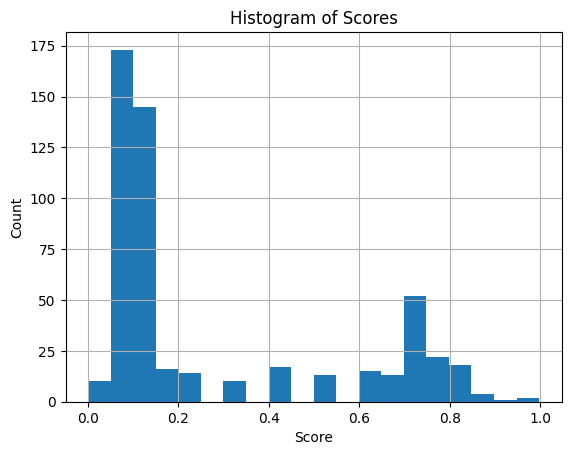

In [ ]:
df['Score'].hist(bins=20)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Histogram of Scores')
plt.grid(True)
plt.show()

From the graph above, we can observe that:

- **Dominant Peak at Low Scores:** <br> A large amount of all reviews fall in the 0.0-0.2 range, forming a very sharp, high-count peak. This reflects a strong bias toward positive sentiment. <br> **Implication**: Our classifier must handle heavy class imbalance; we'll need class weighting or other imbalance-mitigation techniques to avoid simply predicting “Good” everywhere.

- **Secondary Peak at High Scores:** <br> A distinct, smaller peak around 0.7 captures the negative-sentiment reviews. Although much smaller than the "Good" peak, it's nonetheless well-defined. <br> **Implication**: We can reliably identify negative reviews, but need to ensure our model doesn't drown them out—again, class weighting will be key.

- **Sparse Middle Region:** <br> **Very few reviews lie in this interval.** <br> **Implication**: Neutral is under-represented; metrics like F1 for this class will likely be lower unless we specifically oversample or weight it.

## Displaying the Number of Duplicates in our Reviews, and the Descriptive Statistics of the Length of our Reviews


In [ ]:
amount_of_languages = df['Language'].value_counts()
nulls = df.isnull().sum()
number_of_duplicates = df.duplicated(subset='Review', keep=False).sum()

print(f'Number of Review that are duplicates: {number_of_duplicates}')
df['Review'].str.split().apply(len).describe()

Number of Review that are duplicates: 213


,Review
count,527.000000
mean,12.998102
std,12.918507
min,1.000000
25%,7.000000
50%,10.000000
75%,12.000000
max,57.000000


<br><hr><br>

### Duplicates

We can observe from the output above that the amount of rows that are duplicates are 213, a signifcant portion of our reviews. However, we still drop it. Due to the fact we mentioned earlier, that duplicate reviews could have different scores which could mess up our model, and also the fact that we can always generate more data.

<br><hr><br>

### Length of Reviews

- **Short reviews dominate**: The median length is just 10 words, and 75% of reviews are less than or equal to 12 words.

- **High variance**: the standard deviation (about 13) is roughly equal to the mean, indicating a long right tail.


- **Outliers exist**: a few reviews reach up to 57 words. These are rare but will affect padding/truncation choices.


Implications for modeling:

- **Choice of MAX_LEN**: <br> We would need to choose MAX_LEN carefully. We can choose to either cover about 95% of the reviews by setting MAX_LEN = 20, or we can include all data by setting a higher value like MAX_LEN = 50, but at the cost of extra zeros. We will discuss this later.

- **Extremely Short Reviews**: <br> We notice that the minimum length of words for a review is 1. We will proceed to drop words less than 4, because of the following reasons: <br><br>1. **Eliminate context-free extremes** that the model would otherwise "memorize" (e.g. "Exciting" always positive) despite **mixed-sentiment nuances**. <br><br>2. **Reduce misleading training signals**: 1-3 word examples can't express balance (“exciting but plot is bad”), so the **model never learns how to weigh conflicting cues**. <br><br>3. **Sharpen pattern learning** on longer reviews where genuine sentiment emerges from word combinations, improving its ability to **handle nuance** instead of overfitting to single-word shortcuts.

# Number of Reviews per Language

In [ ]:
# Count number of rows per language
language_counts = df['Language'].value_counts().rename_axis('Language').reset_index(name='RowCount')

# Get top 5 rows for each unique value in the 'Language' column
print("------------------ Top 5 Reviews per Language -------------------")
display(df.groupby('Language').head())

print("\n\n------------------- Count of Languages -------------------")
display(language_counts)

------------------ Top 5 Reviews per Language -------------------


,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.100000,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.900000,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.,0.500000,Malay
3,"Sayang sekali, pelakon tidak memberikan persembahan terbaik. Kurang puas hati.",0.800000,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Sungguh menghiburkan!,0.200000,Malay
206,"This movie is amazing! The action is breathtaking, and the plot is intriguing.",0.080000,English
207,I'm disappointed with the actors' performance. Not satisfying.,0.700000,English
208,The storyline is touching and full of emotion. I love it!,0.120000,English
209,This movie delivers an outstanding experience. Truly captivating!,0.050000,English
210,"Too many action scenes, sometimes unnecessary. Too dramatic.",0.400000,English




------------------- Count of Languages -------------------


,Language,RowCount
0,English,298
1,Malay,226
2,Chinese,2
3,Nippon,1


Based on the output, we noticed that there were only **2 rows of Chinese Language, and 1 row of 'Nippon' language** (presumably japanese, because 'Nippon' is one way to say the word 'Japan' in Japanese. The value of the cell further confirms it).

Let's delve deeper:

- First chinese row (row 426): 'Ni hao' means 'hello' in Chinese. This doesn't tell us anything at all! Furthermore, the rating is NaN. Therefore, we cannot use this row at all.

- Second chinese row (row 427): 'Hen tai fei chang hao' probably means 'Very very good'. The rating reflects the review, however, with only one effective row in Chinese, our model might struggle to perform on this. Hence, we will not be using the Chinese Language.

- First Japanese row: 'Nani kore', probably means 'What is this', has a review rating of 0.997. The reviewer was probably baffled by the poor performance of the movie. Hence, the poor rating. However, although this is an effective row, we only have one row of japanese, with only 2 words. Hence, we might as well remove it.

In summary,

We notice that English and Malay dominate this dataset, and they both account for 524 out of the 527 rows of data. Chinese (2) and Nippon (1) are statistical outliers; their sample size is too small to support reliable training or embeddings. Actionable decision: focus our pipeline on English & Malay data; exclude 3 sparse reviews rather than modeling all four languages equally.


## Determining the thresholds for Good, Neutral and Bad Sentiments

For identifying the thresholds for Good, Neutral and Bad Sentiments, we utilize DBSCAN.

### Why DBSCAN?
We used DBSCAN because it identifies high-density regions in the score distribution without forcing a preset cluster count, and naturally separates low-density 'Neutral' scores as their own cluster or noise. After tuning eps=0.09 and min_samples=5 via a k-distance plot and silhouette scores, DBSCAN produced multiple clusters which we then merged into three sentiment buckets—'Good', 'Neutral', and 'Bad', based on their sorted means. This density-based approach ensured our thresholds reflect actual gaps in the data rather than arbitrary splits.

Merging clusters 3 and 2...


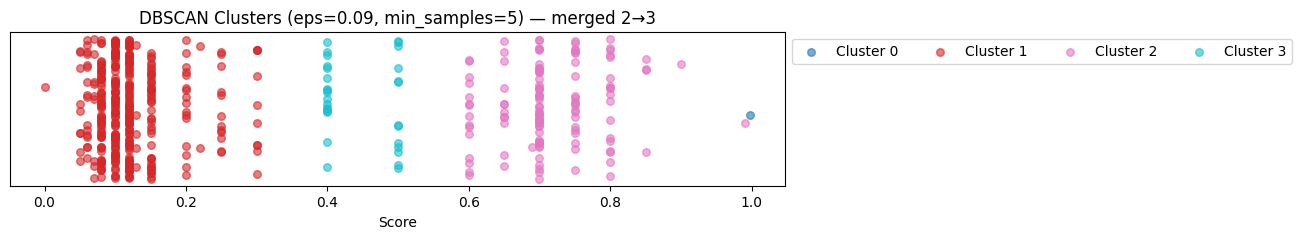

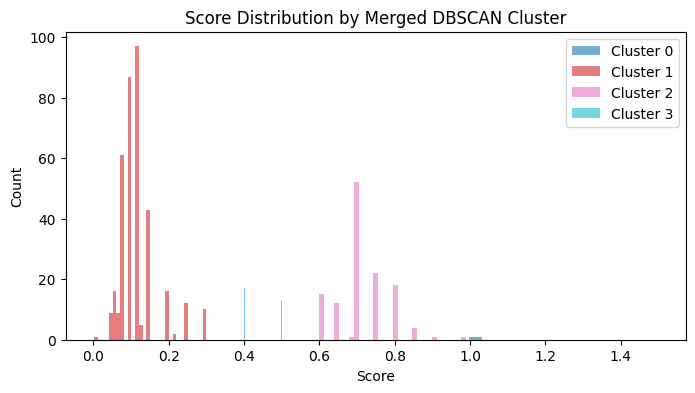

In [ ]:
df_for_db = df.dropna(subset=['Score']).reset_index(drop=True)
X = df_for_db['Score'].values.reshape(-1, 1)

# 2) Run initial DBSCAN
eps_init = 0.09 # This was determined by testing multiple eps values. Best one was 0.09
min_samples = 5 # Similarly, this was tested multiple times.
db = DBSCAN(eps=eps_init, min_samples=min_samples).fit(X)
labels = db.labels_  # -1 = noise, 0,1,2... = clusters

# 3) Identify clusters sorted by their mean score
clusters = sorted(
    [lbl for lbl in set(labels) if lbl >= 0],
    key=lambda lbl: X[labels == lbl].mean()
)
cluster_means = {lbl: float(X[labels == lbl].mean()) for lbl in clusters}

# Pick the two “middle” clusters (by sorted mean) to merge
mid = len(clusters) // 2
c1, c2 = clusters[mid-1], clusters[mid]
print(f"Merging clusters {c1} and {c2}...")

# 4) Manually merge c2 into c1
merged = labels.copy()
merged[labels == c2] = c1

# 5) Renumber labels to 0,1,2,… without gaps
unique_labels = sorted(set(merged))
label_map = {old: new for new, old in enumerate(unique_labels)}
final_labels = np.array([label_map[lbl] for lbl in merged])
df_for_db['db_label'] = final_labels

# 6a) Rug/scatter plot of merged clusters
plt.figure(figsize=(10,2))
cmap = plt.cm.get_cmap('tab10', len(unique_labels))
for old_lbl, new_lbl in label_map.items():
    mask = (final_labels == new_lbl)
    y_jitter = np.random.uniform(-0.02, 0.02, size=mask.sum())
    plt.scatter(
        X[mask], y_jitter,
        s=30, alpha=0.6,
        color=cmap(new_lbl),
        label=f'Cluster {new_lbl}'
    )
plt.yticks([])
plt.xlabel("Score")
plt.title(f"DBSCAN Clusters (eps={eps_init}, min_samples={min_samples}) — merged {c2}→{c1}")
plt.legend(ncol=5, bbox_to_anchor=(1,1), loc='upper left')
plt.show()

# 6b) Stacked histogram by merged cluster
plt.figure(figsize=(8,4))
for new_lbl in sorted(label_map.values()):
    subset = df_for_db.loc[df_for_db.db_label == new_lbl, 'Score']
    plt.hist(subset, bins=30, alpha=0.6,
             color=cmap(new_lbl),
             label=f'Cluster {new_lbl}')
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score Distribution by Merged DBSCAN Cluster")
plt.legend()
plt.show()

# Data Preprocessing

Right now, we will clean and preprocess the data in order to make it ready to be fit into our model.

## Data Cleaning

We labelled reviews with under 0.3 score as 'Good', and above 0.6 as 'Bad'. Anything in between will be labelled as 'Neutral'.


We performed the data cleaning steps that we discussed earlier, for example, removing duplicates, dropping Chinese and Japanese, and dropping reviews less than 4 words. We also label encoded the sentiments, Good, Neutral and Bad into the dataframe.

In [ ]:
def label_sentiment(score):
    if score < 0.3:
        return 'Good'
    elif score > 0.6:
        return 'Bad'
    else:
        return 'Neutral'

# Re-define df, so that earlier steps were reverted
df = pd.read_csv("/content/Movie reviews.csv")

# Drop the unnecessary rows
df = df.drop('Are there ways for you to generate more data? Spliting up sentences, would that help?', axis=1)

# Dropping null values
df = df.dropna(subset=["Review", "Score"])

# Dropping duplicates
df = df.drop_duplicates(subset="Review", keep=False)
df = df.reset_index(drop=True)

# Removing languages that are drastically lacking in data
df = df[~df['Language'].isin(['Chinese', 'Nippon'])]

# Drop reviews too less words
df = df[df['Review'].apply(lambda x: len(str(x).split()) >= 4)].reset_index(drop=True)

df['sentiment'] = df['Score'].apply(label_sentiment)

In [ ]:
# 1) build a combined stratification key to ensure test and val set has all sentiments in english and malay
df['lang_sent'] = df['Language'] + '_' + df['sentiment']

# 80% of all data is training data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['lang_sent'], shuffle=True) # temp_df is just a temporary df to separate later

# the remaining 20% data is split equally between train and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['lang_sent'], shuffle=True)

# drop helper column
for d in (train_df, val_df, test_df):
    d.drop(columns='lang_sent', inplace=True)

print(f'Training shape: {train_df.shape}')
print(f'Validation shape: {val_df.shape}')
print(f'Testing shape: {test_df.shape}')

Training shape: (146, 4)
Validation shape: (31, 4)
Testing shape: (32, 4)


### Showing the Validation and Test Splits

This is to ensure everything is stratified. For example, **our test set doesn't contain all good reviews.** This make sure our results aren't **biased towards one sentiment**, and perform poorly on the others.

In [ ]:
print("----------------- Train Set -----------------")
display(train_df.groupby('sentiment')['Language'].value_counts())
print("\n\n----------------- Validation Set -----------------")
display(val_df.groupby('sentiment')['Language'].value_counts())
print("\n\n----------------- Test Set -----------------")
display(test_df.groupby('sentiment')['Language'].value_counts())

----------------- Train Set -----------------


sentiment  Language
Bad        English     21
           Malay        6
Good       English     82
           Malay       20
Neutral    English     13
           Malay        4
Name: count, dtype: int64



----------------- Validation Set -----------------


sentiment  Language
Bad        English      5
           Malay        1
Good       English     17
           Malay        4
Neutral    English      3
           Malay        1
Name: count, dtype: int64



----------------- Test Set -----------------


sentiment  Language
Bad        English      4
           Malay        1
Good       English     18
           Malay        5
Neutral    English      3
           Malay        1
Name: count, dtype: int64

## Data Creation

We observed a **severe imbalance in our training set's language distribution, so our first step is to equalize English and Malay reviews** through intelligent oversampling rather than blunt duplication. To do this, we **back-translate each Malay review into English, feed it through the T5-paraphraser to generate a fluent variant, then translate the paraphrase back into Malay—giving us high-quality synthetic Malay examples that bring both languages into rough parity.**

Rather than attempt a **second round of resampling for sentiment labels**, which would **risk overfitting** on repeated texts, we handle the remaining "Good," "Neutral," and "Bad" class imbalance in training. **By supplying class weights to the loss function**, we charge more whenever the model misclassifies a rare sentiment, ensuring it pays extra attention to minority classes without duplicating data. <br> **Furthermore, later on, we initialize the final layer's bias to reflect each sentiment's prior frequency** (e.g. using log(freq_majority/freq_current)), so that the network starts from a position consistent with our overall distribution and only needs to fine-tune toward true separation.

<br>

**This two-stage strategy gives us balanced language coverage and a authentic method of handling label skew, all without discarding or overly repeating any examples.**

<br><hr><br>

**You might ask: "I understand, but why not just balance the sentiment instead of the languages? Why did you only choose to balance the languages, but not the sentiment?"** <br> This is because we want our model to see roughly equal amounts of English, Malay, etc., so that it doesn't **overfit to English-only patterns or vocabulary**. Class weights and bias initialization is a **great alternative and has less overfitting risk.**


Note: In our code, I used caching. You might wonder why, and here's an explantion: <br> Since our deep-translator works on sending HTTP requests in order to translate, I utilized methods such as caching in order to reduce the time taken to translate, maximizing our efficiency.


<br><hr><br>

Link to HuggingFace: https://huggingface.co/ramsrigouthamg/t5_paraphraser

### Plotting the distribution of Train Scores (Pre-Balancing)

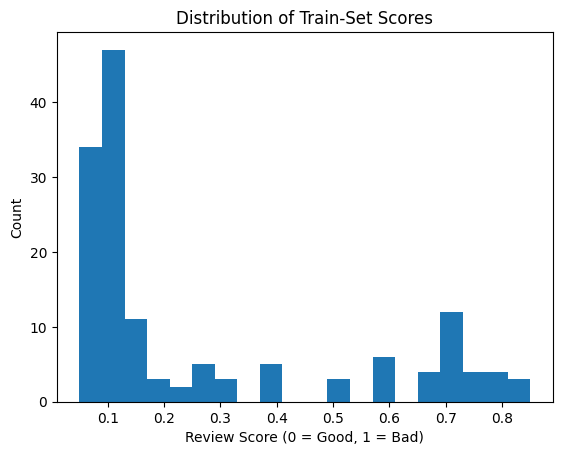

In [ ]:
plt.figure()
plt.hist(train_df['Score'], bins=20)
plt.xlabel('Review Score (0 = Good, 1 = Bad)')
plt.ylabel('Count')
plt.title('Distribution of Train‐Set Scores')
plt.show()

### Sentiment Portion Per Language (Pre-Balancing)

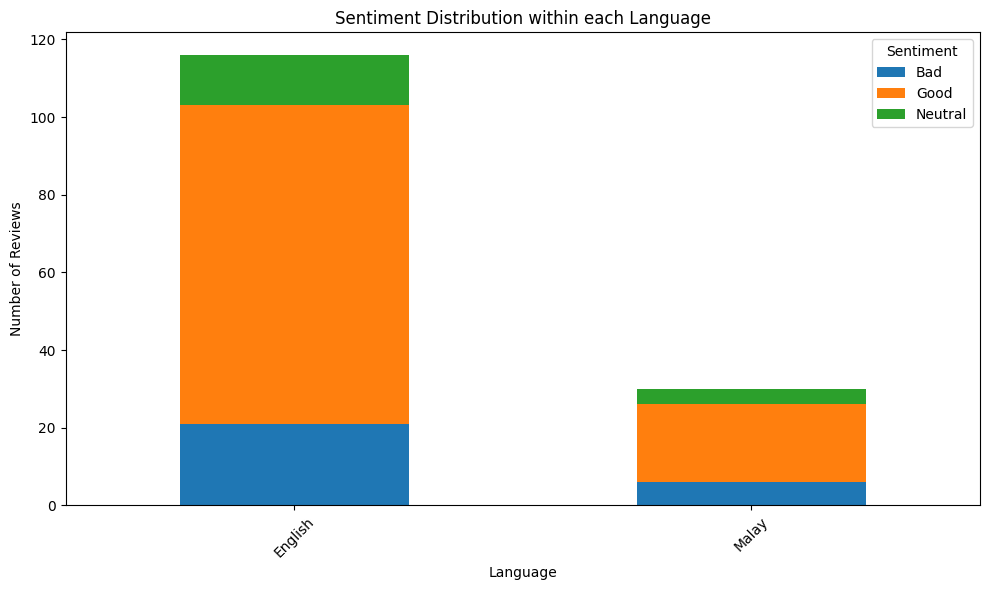

In [ ]:
# Group by language first, then sentiment
language_counts = train_df.groupby(['Language', 'sentiment']).size().unstack(fill_value=0)

# Plot a stacked bar chart
language_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Sentiment Distribution within each Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Balancing of Languages




In [ ]:
from functools import lru_cache

# --- 0) setup paraphraser / translators ---
model_name  = "ramsrigouthamg/t5_paraphraser"
tok         = AutoTokenizer.from_pretrained(model_name)
mod         = AutoModelForSeq2SeqLM.from_pretrained(model_name)
paraphraser = pipeline(
    "text2text-generation",
    model=mod, tokenizer=tok,
    device=0, framework="pt", max_length=256
)
ms2en = GoogleTranslator(source="ms", target="en")
en2ms = GoogleTranslator(source="en", target="ms")

# --- 1) Count languages, get target max_count ---
lang_counts = train_df["Language"].value_counts()
max_count   = lang_counts.max()

# --- 2) Fit TF-IDF on originals ---
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
vectorizer.fit(train_df["Review"].tolist())

def is_good_similarity(orig, cand,
                       min_sim = 0.3,
                       max_sim = 0.8):
    v = vectorizer.transform([orig, cand])
    sim = cosine_similarity(v[0], v[1])[0,0]
    return min_sim < sim < max_sim

# --- 3) Caching back-translation --- (used for reducing time taken to translate)
@lru_cache(maxsize=None)
def translate_ms2en(text): return ms2en.translate(text)
@lru_cache(maxsize=None)
def translate_en2ms(text): return en2ms.translate(text)

# --- 4) High-quality variant generator ---
def high_quality_variants(orig: str, lang: str, need: int):
    if lang.lower() in ("en","english"):
        prompt = f"paraphrase: {orig}"
    else:
        en = translate_ms2en(orig)
        prompt = f"paraphrase: {en}"
    raw = paraphraser(
        prompt,
        num_beams=need*5,
        num_return_sequences=need*5,
        do_sample=True,
        temperature=1.0,
        no_repeat_ngram_size=3,
        repetition_penalty=1.1,
    )
    if isinstance(raw[0], list):
        raw = [o for sub in raw for o in sub]

    candidates = []
    for o in raw:
        txt = o["generated_text"].strip()
        if not txt:
            continue
        if lang.lower() not in ("en","english"):
            txt = translate_en2ms(txt)
        if is_good_similarity(orig, txt):
            candidates.append(txt)
        if len(candidates) >= need:
            break
    return candidates

# --- 5) Balance by language ---
to_augment = []
seen       = set(train_df["Review"].str.lower())

for lang, n_orig in lang_counts.items():
    need = max_count - n_orig
    if need <= 0:
        continue

    cls_df = train_df[train_df["Language"] == lang]
    # how many variants per original to over-generate
    per_orig = ceil(need / n_orig)

    added = 0
    for _, row in cls_df.iterrows():
        if added >= need:
            break
        orig, score, sent = row["Review"], row["Score"], row["sentiment"]
        variants = high_quality_variants(orig, lang, per_orig)
        for txt in variants:
            if added >= need:
                break
            if txt.lower() in seen:
                continue
            to_augment.append({
                "Review":    txt,
                "Score":     score,
                "Language":  lang,
                "sentiment": sent
            })
            seen.add(txt.lower())
            added += 1

# --- 6) Build new DataFrame and inspect ---
aug_df         = pd.DataFrame(to_augment)
train_balanced = pd.concat([train_df, aug_df], ignore_index=True)

print("Language counts before:", lang_counts.to_dict())
print("Language counts after :", train_balanced["Language"].value_counts().to_dict())

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Language counts before: {'English': 116, 'Malay': 30}
Language counts after : {'English': 116, 'Malay': 95}


We can observe that the languages are roughly balanced, greatly preventing the risk of our model overfitting on english vocabulary and text patterns!

### Distribution of Train Scores (Post-Balancing)

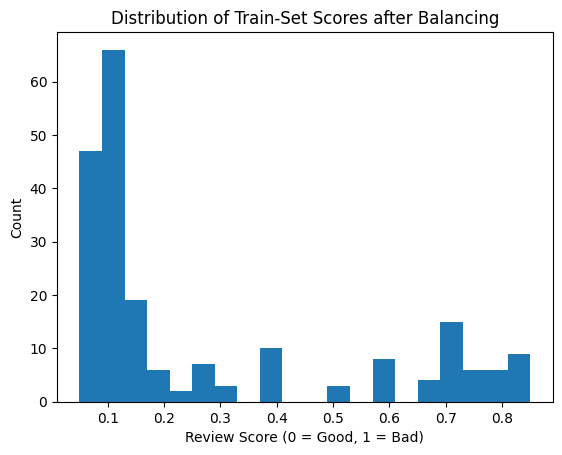

In [ ]:
plt.figure()
plt.hist(train_balanced['Score'], bins=20)
plt.xlabel('Review Score (0 = Good, 1 = Bad)')
plt.ylabel('Count')
plt.title('Distribution of Train‐Set Scores after Balancing')
plt.show()

### Sentiment Portion Per Language (Post-Balancing)

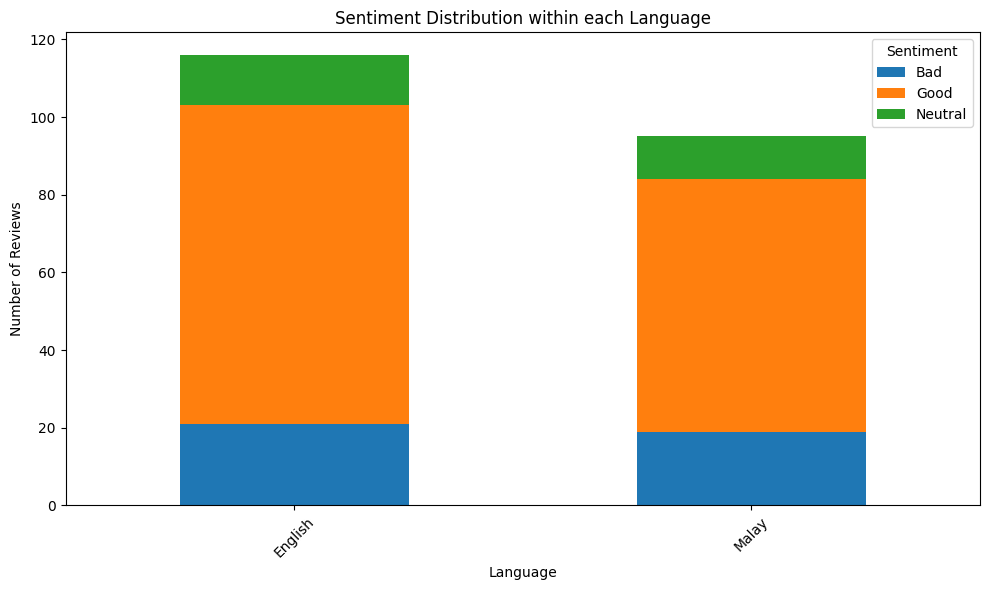

In [ ]:
# Group by language first, then sentiment
language_counts = train_balanced.groupby(['Language', 'sentiment']).size().unstack(fill_value=0)

# Plot a stacked bar chart
language_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Sentiment Distribution within each Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From here, we can highlight the important effect balancing has done for us.

### Mutliplying the reviews

What this does is we **paraphrase an original review 4 times**, and now we have the original review and 4 other paraphrased review. Hence, now, **we have 5x the amount of reviews.**

<br>

#### Why?

By "multiplying" each original review into five paraphrases, we inject controlled linguistic diversity that **helps the model generalize**. Each synthetic variant preserves the core sentiment but uses different wording, so **our network sees multiple ways of expressing the same idea**. This reduces overfitting to any one phrasing, bolsters performance on low-resource segments, and effectively simulates having **five times more real reviews without changing the underlying distribution**.

In [ ]:
from functools import lru_cache
from tqdm import tqdm # used to show a progress bar, so we know when we are about to be done

# 1) single‐shot caches for deep-translator
@lru_cache(maxsize=None)
def translate_ms2en(text):
    return ms2en.translate(text)

@lru_cache(maxsize=None)
def translate_en2ms(text):
    return en2ms.translate(text)

# 2) augment returns up to k candidates in one call
def augment(orig: str, lang: str, k: int = 4):
    # build prompt
    if lang.lower() in ("en", "english"):
        prompt = f"paraphrase: {orig}"
    else:
        prompt = f"paraphrase: {translate_ms2en(orig)}"

    # call pipeline with sampling for diversity
    outs = paraphraser(
        [prompt],
        batch_size=1,
        num_return_sequences=k,
        do_sample=True,
        top_p=0.9,
        temperature=1.0,
        no_repeat_ngram_size=2,
        repetition_penalty=1.2,
        num_beams=1
    )

    # flatten if nested
    if isinstance(outs[0], list):
        outs = outs[0]

    # extract texts & back-translate Malay if needed
    results = []
    for o in outs:
        txt = o["generated_text"].strip()
        if not txt:
            continue
        if lang.lower() not in ("en","english"):
            txt = translate_en2ms(txt)
        results.append(txt)
    return results

# 3) Multiply‐by‐K loop
MULTIPLY_FACTOR = 5
K = MULTIPLY_FACTOR - 1

paraphrases = []
seen        = set(s.lower() for s in train_balanced["Review"])

for _, row in tqdm(train_balanced.iterrows(), total=len(train_balanced)):
    orig, lang, score, sent = (
        row["Review"],
        row["Language"],
        row["Score"],
        row["sentiment"]
    )
    cands = augment(orig, lang, k=K)

    added = 0
    for cand in cands:
        if added >= K:
            break
        norm = cand.lower().strip()
        if norm in seen:
            continue
        paraphrases.append({
            "Review":    cand,
            "Score":     score,
            "Language":  lang,
            "sentiment": sent
        })
        seen.add(norm)
        added += 1

    # pad with original if we didn’t hit K
    while added < K:
        paraphrases.append({
            "Review":    orig,
            "Score":     score,
            "Language":  lang,
            "sentiment": sent
        })
        added += 1

# 4) Build the final DataFrame
par_df            = pd.DataFrame(paraphrases)
train_augmented   = pd.concat([train_balanced, par_df], ignore_index=True)

print("Original size:", len(train_balanced))
print(f"After x{MULTIPLY_FACTOR}:", len(train_augmented))

100%|██████████| 211/211 [07:02<00:00,  2.00s/it]

Original size: 211
After x5: 1055


### Distribution of Train Scores (Post-Balancing and Augmentation)

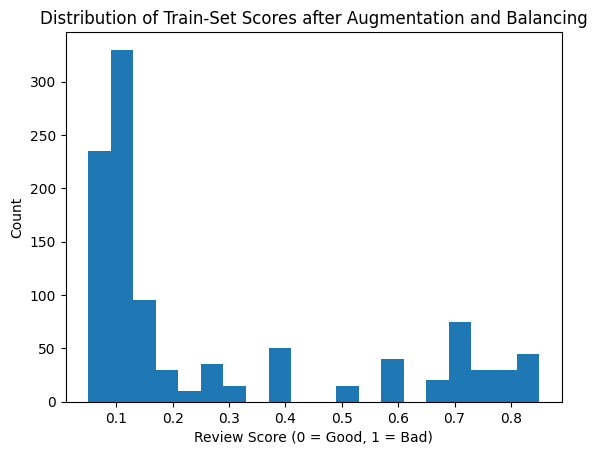

In [ ]:
plt.figure()
plt.hist(train_augmented['Score'], bins=20)
plt.xlabel('Review Score (0 = Good, 1 = Bad)')
plt.ylabel('Count')
plt.title('Distribution of Train‐Set Scores after Augmentation and Balancing')
plt.show()

### Sentiment Portion Per Language (Post-Balancing and Augmentation)

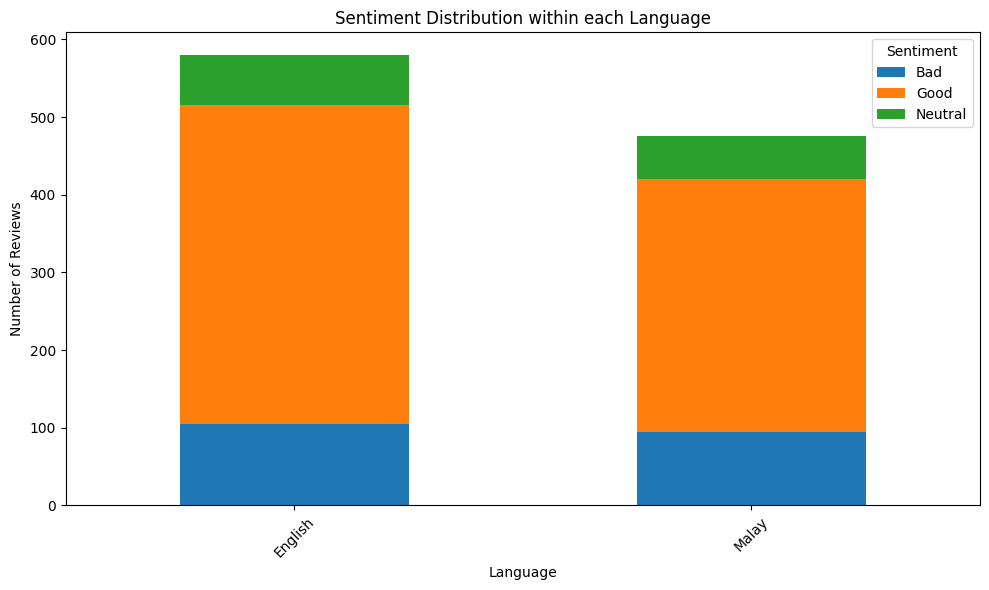

In [ ]:
# Group by language first, then sentiment
language_counts = train_augmented.groupby(['Language', 'sentiment']).size().unstack(fill_value=0)

# Plot a stacked bar chart
language_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Sentiment Distribution within each Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Checking for similarity

Since we used a T5 to paraphrase our reviews, we need to check if the **paraphrased reviews have any similarity to our Validation or Test reviews**, so as to **prevent this step of slight overfitting that might occur.**

In [ ]:
def remove_overlapping_reviews(train_df, val_df, review_col= 'Review'):
    # Create normalized helper column for matching
    train_df['__normalized_review'] = train_df[review_col].str.strip().str.lower()
    val_reviews_set = set(val_df[review_col].str.strip().str.lower())

    # Filter in-place
    train_df.drop(train_df[train_df['__normalized_review'].isin(val_reviews_set)].index, inplace=True)

    # Drop the helper column
    train_df.drop(columns='__normalized_review', inplace=True)

    print("Overlapping reviews removed. Remaining rows:", len(train_df))

train_reviews_set = set(train_augmented['Review'].str.strip().str.lower())
val_reviews_set = set(val_df['Review'].str.strip().str.lower())

# Find any overlapping reviews
overlapping_reviews = train_reviews_set.intersection(val_reviews_set)

# Check and report
if overlapping_reviews:
    print("Overlap found:")
    for review in overlapping_reviews:
        print(review)
    remove_overlapping_reviews(train_augmented, val_df, 'Review')
else:
    print("No review in train_augmented appears in val_df!")

No review in train_augmented appears in val_df!


In [ ]:
train_reviews_set = set(train_augmented['Review'].str.strip().str.lower())
test_reviews_set = set(test_df['Review'].str.strip().str.lower())

# Find any overlapping reviews
overlapping_reviews = train_reviews_set.intersection(test_reviews_set)

# Check and report
if overlapping_reviews:
    print("Overlap found:")
    for review in overlapping_reviews:
        print(review)
    remove_overlapping_reviews(train_augmented, test_df, 'Review')
else:
    print("No review in train_augmented appears in test_df!")

No review in train_augmented appears in test_df!


## Text Normalization

- **Raw cleaning & Unicode normalization**: WE normalize all text to Unicode NFKC and lowercase it, so visually identical characters can't sneak in as different tokens. Stripping HTML tags, URLs, email addresses, and collapsing whitespace removes boilerplate noise that doesn't carry sentiment, ensuring that our model focuses on the actual review content. (Some of this aren't in the dataset, but placed here for extra precaution.)

- **English contraction expansion**: Turning "can't" → "cannot," "i'm" → "i am," etc., standardizes alternative spellings and preserves negation in full form, which is crucial for sentiment detection.

- **Stop-word removal & lemmatization (English)**: We drop common English stop-words (minus "not," "no," "nor" so negation cues remain) to reduce the input vocabulary and speed up learning, then lemmatize each token so that variants like "running" and "ran" collapse to "run." This both shrinks our feature space and helps the model generalize over morphological variants.


- **Custom Malay stop-words**: By filtering out high-frequency Malay function words (e.g. "dan," "di," "untuk," etc.) but not removing negations ("tidak," "jangan," "tak"), we analogously eliminate noise in Malay text while preserving the polarity flips that those negation words convey.


- **Boundary tokens**: Wrapping each cleaned sequence with `<start>` and `<end> `gives our model explicit signals about sequence limits, which is especially helpful for our models.

- **Tokenizing**: Fitting a single Keras Tokenizer on both real and augmented texts ensures a unified vocabulary (with an <OOV> fallback for rare words) so that synthetic paraphrases and originals are encoded consistently.

- **Label mapping**: Finally, mapping "Good," "Neutral," and "Bad" to integer indices completes the pipeline, producing arrays that feed directly into our model.

In [ ]:
@lru_cache(maxsize=None)
def translate_ms2en(text):
    try:
        return ms2en.translate(text)
    except Exception:
        # fallback to original or empty
        return text

@lru_cache(maxsize=None)
def translate_en2ms(text):
    try:
        return en2ms.translate(text)
    except Exception:
        # fallback to original or empty
        return text

# Map our sentiments to integer labels
sent2idx = {'Good':0, 'Neutral':1, 'Bad':2}

# ——— Raw cleaning & Unicode normalization ———
def clean_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = text.lower()  # Move this here!
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ——— English contraction expansion ———
CONTRACTIONS = {
    "can't": "cannot",
    "won't": "will not",
    "i'm":   "i am",
    "it's":  "it is",
    "don't": "do not"
}
_contr_re = re.compile(r"\b(" + "|".join(CONTRACTIONS.keys()) + r")\b")

def expand_contractions(text):
    return _contr_re.sub(lambda m: CONTRACTIONS[m.group(0)], text)

# ——— Setup lemmatizer and custom stopwords ———
lemmatizer = WordNetLemmatizer()
# Remove 'not' and 'no' from stopwords to preserve negation cues
custom_stop_en = set(ENGLISH_STOP_WORDS) - {"not", "no", "nor"}

custom_stop_ms = {
    "dan", "di", "ke", "daripada", "yang", "untuk", "dengan",
    "pada", "adalah", "ini", "itu", "oleh", "atau", "serta",
    "sebagai", "semasa", "antara", "kerana", "supaya", "tetapi",
    "jika", "manakala"
}

# ——— preprocess_text ———
def preprocess_text(text, lang):
    # 1) Clean and normalize
    txt = clean_text(text)

    if lang.lower() in ("en", "english"):
        # 2) Expand English contractions
        txt = expand_contractions(txt)

        # 3) Tokenize, remove stopwords, lemmatize
        tokens = txt.split()
        tokens = [t for t in tokens if t not in custom_stop_en]
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    else: # For non-English (e.g., Malay), skip stopword removal, lemmatization, and contraction expansion
        tokens = txt.split()
        tokens = [t for t in tokens if t not in custom_stop_ms]

    # 4) Reconstruct with boundary tokens
    final_text = " ".join(tokens)
    return f"<start> {final_text} <end>"


# ——— Apply to our DataFRames ———
# assume train_df and train_augmented exist with “Review” and “Score”
train_df["cleaned"] = train_df.apply(
    lambda row: preprocess_text(row["Review"], row["Language"]),
    axis=1
)
train_augmented["cleaned"] = train_augmented.apply(
    lambda row: preprocess_text(row["Review"], row["Language"]),
    axis=1
)

# ——— Tokenizer and sequence conversion ———
MAX_LEN = 50    # sequence length
VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
# build vocab on the combined (real + augmented) texts
tokenizer.fit_on_texts(
    pd.concat([train_df["cleaned"], train_augmented["cleaned"]])
)

VOCAB_SIZE = min(5000, len(tokenizer.word_index) + 1)

# convert to integer lists
seqs_real = tokenizer.texts_to_sequences(train_df["cleaned"])
seqs_aug = tokenizer.texts_to_sequences(train_augmented["cleaned"])

# ——— 8) Padding: make every sequence length == MAX_LEN ———
# this adds zeros (“<pad>”) at the end (post-padding)
X_train = pad_sequences(seqs_real, maxlen=MAX_LEN, padding="post")
X_train_augmented  = pad_sequences(seqs_aug,  maxlen=MAX_LEN, padding="post")

y_train = train_df['sentiment'].map(sent2idx).values
y_train_augmented = train_augmented['sentiment'].map(sent2idx).values

print("Vocab size (incl. OOV):", VOCAB_SIZE)
print("X_train shape:", X_train.shape)
print("X_train_aug shape:", X_train_augmented.shape)

Vocab size (incl. OOV): 1173
X_train shape: (146, 50)
X_train_aug shape: (1055, 50)


After performing text preprocessing on our train set, we do the same for the test and validation set below

In [ ]:
# -------------------------------------- Validation --------------------------------------
# 2) Tag the val and test DataFrames
val_df['sentiment']  = val_df['Score'].apply(label_sentiment)
test_df['sentiment'] = test_df['Score'].apply(label_sentiment)


# ——— Apply preprocessing to val_df ———
val_df["cleaned"] = val_df.apply(
    lambda row: preprocess_text(row["Review"], row["Language"]),
    axis=1
)

# ——— Convert val text to sequences using the existing tokenizer ———
seqs_val = tokenizer.texts_to_sequences(val_df["cleaned"])

# ——— Pad val sequences to match training shape ———
X_val = pad_sequences(seqs_val, maxlen=MAX_LEN, padding="post")
y_val = val_df['sentiment'].map(sent2idx).values

# Optional sanity check
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


# -------------------------------------- Test --------------------------------------

# ——— Apply preprocessing to test_df ———
test_df["cleaned"] = test_df.apply(
    lambda row: preprocess_text(row["Review"], row["Language"]),
    axis=1
)

# ——— Convert test text to sequences using the existing tokenizer ———
seqs_test = tokenizer.texts_to_sequences(test_df["cleaned"])

# ——— Pad test sequences to match model input shape ———
X_test = pad_sequences(seqs_test, maxlen=MAX_LEN, padding="post")
y_test = test_df['sentiment'].map(sent2idx).values

# Optional sanity check
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_val shape: (31, 50)
y_val shape: (31,)
X_test shape: (32, 50)
y_test shape: (32,)


## Class Weights


As mentioned earlier, after balancing languages through targeted oversampling, we still see residual skews in the "Good," "Neutral," and "Bad" labels, both before and after augmentation, so we compute separate class-weight schemes on each dataset. Using scikit-learn's class weight computation, we set each sentiment's penalty inversely proportional to its frequency.

<br>

**This ensures our loss function automatically pays extra attention to minority classes** without duplicating examples, keeping training aligned with the true label distribution in both the original and augmented dataset. (I computed class weights for both the augmented and non-augmented dataset.)

In [ ]:
classes = np.unique(y_train)   # [0,1,2]
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

aug_classes = np.unique(y_train_augmented)
aug_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=aug_classes,
    y=y_train_augmented
)

class_weights = {cls: w for cls, w in zip(classes, weights)}
aug_class_weights = {cls: w for cls, w in zip(aug_classes, aug_weights)}
# Reverse the mapping from integers back to labels
idx2sent = {v: k for k, v in sent2idx.items()}
# Remap the class weights to use labels instead of integers
labelled_class_weights = {idx2sent[cls]: weight for cls, weight in class_weights.items()}
augmented_labelled_class_weights = {idx2sent[cls]: weight for cls, weight in aug_class_weights.items()}
print(f'NonAugmented Class Weights: {labelled_class_weights}')
print(f'Augmented Class Weights: {augmented_labelled_class_weights}')

NonAugmented Class Weights: {'Good': np.float64(0.477124183006536), 'Neutral': np.float64(2.8627450980392157), 'Bad': np.float64(1.8024691358024691)}
Augmented Class Weights: {'Good': np.float64(0.47845804988662133), 'Neutral': np.float64(2.9305555555555554), 'Bad': np.float64(1.7583333333333333)}


# Modelling

## Callbacks

We will use early stopping and reduce learning rate on plateau. We customized our early stopping to **start from epoch 15**, to maximise training for all our models.

Keep in mind that the following models have a total of 20 epochs, so it is guaranteed for them to train to the max of 20 epochs. However, when we later define our best model, we train for 30 epochs, so that is where this cusotmization shines.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

## Bias Initializer


Initializing the final-layer bias to the log-ratio of class frequencies gives the network a head start on the true sentiment distribution before it sees any data.

<br>

Instead of beginning with uniform priors and having to "unlearn" our skewed label mix, the model's raw outputs initially reflect the observed Good/Neutral/Bad proportions, speeding convergence and stabilizing early training—especially for underrepresented classes, while **working hand-in-hand with class weights to produce fair, calibrated predictions**.

In [ ]:
counts = np.bincount(y_train)
freqs = counts / counts.sum()
print('Frequencies: ' + str({i: f"{freq:.2%}" for i, freq in enumerate(freqs)}))

prior = counts / counts.sum()
bias_init = np.log(prior + 1e-8)
print(f'Bias Initializer: {bias_init}')


aug_counts = np.bincount(y_train_augmented)
aug_freqs = aug_counts / aug_counts.sum()
print('\n\nAugmented Frequencies: ' + str({i: f"{freq:.2%}" for i, freq in enumerate(aug_freqs)}))

aug_prior = aug_counts / aug_counts.sum()
aug_bias_init = np.log(aug_prior + 1e-8)

print(f'Augmented Bias Initializer: {aug_bias_init}')

Frequencies: {0: '69.86%', 1: '11.64%', 2: '18.49%'}
Bias Initializer: [-0.35863379 -2.15039319 -1.6877697 ]


Augmented Frequencies: {0: '69.67%', 1: '11.37%', 2: '18.96%'}
Augmented Bias Initializer: [-0.36142553 -2.17380422 -1.66297863]


In [ ]:
# A function to store all the model's histories into a dataframe for nice display later.
def history_to_df(history, model_name):
    h = history.history

    def get_metric(key):
        return h[key][-1] if key in h else None

    return pd.DataFrame({
        'model': [model_name],
        'final_val_accuracy': [get_metric('val_accuracy')],
        'final_val_precision': [get_metric('val_precision_m')],
        'final_val_recall': [get_metric('val_recall_m')],
        'final_val_f1': [get_metric('val_f1_m')]
    })

## Custom Metrics

In sentiment analysis, especially when most reviews are "Good" and only a few are "Neutral" or "Bad," **using accuracy by itself can be misleading**. A model could just **predict "Good" all the time and still get a high accuracy**, but that **wouldn't be helpful if we care about catching the less common negative or neutral reviews**.

<br>

**That's why I chose to use precision, recall, and F1 score**. Precision helps us check **how often the model is right when it says a review is "Neutral" or "Bad."** This matters because we don't want to wrongly label positive reviews as negative. Recall tells us **how many of the actual "Neutral" or "Bad" reviews the model is able to find**. This is important so we don't miss important feedback.

<br>

The F1 score gives a balance between precision and recall, combining both into one number. **These metrics together give a much clearer picture of how well the model is doing with all types of sentiment, especially when the classes aren't evenly split.**

In [ ]:
NUM_CLASSES = 3
EPS = tf.keras.backend.epsilon()   # grab it once

def precision_m(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_o = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    y_pred_o = tf.one_hot(tf.cast(y_pred_labels, tf.int32), depth=NUM_CLASSES)
    tp = tf.reduce_sum(tf.cast(y_true_o * y_pred_o, tf.float32))
    pp = tf.reduce_sum(tf.cast(y_pred_o, tf.float32))
    return tp / (pp + EPS)

def recall_m(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_o = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    y_pred_o = tf.one_hot(tf.cast(y_pred_labels, tf.int32), depth=NUM_CLASSES)
    tp = tf.reduce_sum(tf.cast(y_true_o * y_pred_o, tf.float32))
    pos = tf.reduce_sum(tf.cast(y_true_o, tf.float32))
    return tp / (pos + EPS)

def f1_m(y_true, y_pred):
    p = precision_m(y_true, y_pred)
    r = recall_m(y_true, y_pred)
    return 2 * p * r / (p + r + EPS)

## Simple RNN


- Embedding layer <br> Maps each of the MAX_LEN integer tokens into a dense embed_dim-dimensional vector

<br>

- Recurrent layer <br> `build_simple_rnn`: A SimpleRNN layer maintains a single hidden state that's updated at each time step via a tanh activation, allowing it to capture short-term dependencies by propagating information forward through the sequence. It's lightweight and fast but can struggle with very long-range patterns due to vanishing gradients. <br> `build_bidirectional_simple_rnn`: Using a bidirectional SimpleRNN reads inputs in both directions, giving it access to both past and future context for each time step, which can improve its ability to detect sentiment cues that depend on surrounding words.

<br>

- Dropout <br> Applies dropout with rate dropout_rate to the RNN outputs to reduce overfitting

<br>

- Output Dense layer <br> Projects into num_classes=3 logits with a softmax activation <br><br> Includes L2 kernel regularization (l2_reg) <br><br> Initializes biases via a constant initializer (bias_initializer) to encode prior class frequencies

<br>

- Compilation settings <br> Optimizer: Adam with learning rate lr <br><br> Loss: sparse_categorical_crossentropy for integer-encoded labels <br><br> Metrics: accuracy plus custom precision, recall, and F1 to monitor performance under class imbalance <br><br> Model names: Named "simple_rnn" and "simple_bi_rnn" respectively, making them easy to identify in summaries and checkpoints

In [ ]:
def build_simple_rnn(bias_initializer, embed_dim=32, rnn_units=32,
                     dropout_rate=0.5, num_classes=3, lr=1e-3, l2_reg=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embed_dim,
            input_shape=(MAX_LEN,),
            mask_zero=True,
        ),
        tf.keras.layers.SimpleRNN(rnn_units),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(
            units=num_classes,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            bias_initializer=tf.constant_initializer(bias_initializer),
            name="output"
        )
    ], name="simple_rnn")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )
    return model

def build_bidirectional_simple_rnn(bias_initializer, embed_dim=32, rnn_units=32,
                                   dropout_rate=0.5, num_classes=3, lr=1e-3, l2_reg=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embed_dim,
            input_shape=(MAX_LEN,),
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.SimpleRNN(rnn_units)
        ),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(
            units=num_classes,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            bias_initializer=tf.constant_initializer(bias_init),
            name="output"
        )
    ], name="simple_bi_rnn")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    return model

In [ ]:
# Instantiate
simple_rnn = build_simple_rnn(bias_init)
aug_simple_rnn = build_simple_rnn(aug_bias_init)
# Bidirectional Version
simple_bi_rnn = build_bidirectional_simple_rnn(bias_init)
aug_simple_bi_rnn = build_bidirectional_simple_rnn(aug_bias_init)

# Display Model Summary (only displayed one per type, because same architecture)
print("SimpleRNN")
aug_simple_rnn.summary()
print("\n\n\n\nSimple Bidirectional RNN")
aug_simple_bi_rnn.summary()

SimpleRNN


Model: "simple_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 32)         │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,235 (153.26 KB)

 Trainable params: 39,235 (153.26 KB)

 Non-trainable params: 0 (0.00 B)





Simple Bidirectional RNN


Model: "simple_bi_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 32)         │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,411 (161.76 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
simple_rnn_history = simple_rnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
aug_simple_rnn_history = aug_simple_rnn.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=aug_class_weights,
    callbacks=[early_stopping, reduce_lr]
)
simple_bi_rnn_history = simple_bi_rnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
aug_simple_bi_rnn_history = aug_simple_bi_rnn.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=aug_class_weights,
    callbacks=[early_stopping, reduce_lr]
)


df_simple_rnn = history_to_df(simple_rnn_history, 'SimpleRNN')
df_bi_simple_rnn = history_to_df(simple_bi_rnn_history, 'Bidirectional SimpleRNN')
df_aug_simple_rnn = history_to_df(aug_simple_rnn_history, 'Augmented SimpleRNN')
df_aug_bi_simple_rnn = history_to_df(aug_simple_bi_rnn_history, 'Augmented Bidirectional SimpleRNN')

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 656ms/step - accuracy: 0.6973 - f1_m: 0.6964 - loss: 1.4451 - precision_m: 0.6964 - recall_m: 0.6964 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8338 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6877 - f1_m: 0.6868 - loss: 1.3439 - precision_m: 0.6868 - recall_m: 0.6868 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8252 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6975 - f1_m: 0.6994 - loss: 1.2084 - precision_m: 0.6994 - recall_m: 0.6994 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8252 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7760 - f1_m: 0.7781 - loss: 1.0002 - precision_m: 0.7781 - recall_m: 0.7781 - val_accuracy: 0.6774 - val_f1_m: 0.6774

## LSTM


- Embedding layer <br> Maps each of the MAX_LEN integer tokens into a dense embed_dim-dimensional vector

<br>

- Recurrent layer <br> `build_lstm`: The LSTM layer uses gated memory cells—input, forget and output gates—to selectively retain or discard information, which lets it capture long-range dependencies (e.g. early negations or sentiment flips) without suffering vanishing gradients. <br> `build_bidirectional_lstm`: Wrapping it in a Bidirectional LSTM doubles that context by reading the sequence forwards and backwards, so the model can consider both preceding and succeeding words when forming its sentiment prediction.

<br>

- Dropout <br> Applies dropout with rate dropout_rate to the RNN outputs to reduce overfitting

<br>

- Output Dense layer <br> Projects into num_classes=3 logits with a softmax activation <br><br> Includes L2 kernel regularization (l2_reg) <br><br> Initializes biases via a constant initializer (bias_initializer) to encode prior class frequencies

<br>

- Compilation settings <br> Optimizer: Adam with learning rate lr <br><br> Loss: sparse_categorical_crossentropy for integer-encoded labels <br><br> Metrics: accuracy plus custom precision, recall, and F1 to monitor performance under class imbalance <br><br> Model names: Named "simple_rnn" and "simple_bi_rnn" respectively, making them easy to identify in summaries and checkpoints

In [ ]:
def build_lstm(bias_initializer, embed_dim=32, lstm_units=32,
               dropout_rate=0.5, num_classes=3, lr=1e-3, l2_reg=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embed_dim,
            input_shape=(MAX_LEN,),
            mask_zero=True,
        ),
        tf.keras.layers.LSTM(lstm_units, name="lstm"),
        tf.keras.layers.Dropout(dropout_rate, name="dropout"),
        tf.keras.layers.Dense(
            units=num_classes,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            bias_initializer=tf.constant_initializer(bias_init),
            name="output"
        )
    ], name="lstm_classifier")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    return model


def build_bidirectional_lstm(bias_initializer, embed_dim=32, lstm_units=32,
               dropout_rate=0.5, num_classes=3, lr=1e-3, l2_reg=0.003):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embed_dim,
            input_shape=(MAX_LEN,),
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_units),
            name="bilstm"
        ),
        tf.keras.layers.Dropout(dropout_rate, name="dropout"),
        tf.keras.layers.Dense(
            units=num_classes,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            bias_initializer=tf.constant_initializer(bias_init),
            name="output"
        )
    ], name="bilstm_classifier")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )
    return model

In [ ]:
# Instantiate
lstm_model = build_lstm(bias_init)
bi_lstm_model = build_bidirectional_lstm(bias_init)

# Augmented
aug_lstm_model = build_lstm(aug_bias_init)
aug_bi_lstm_model = build_bidirectional_lstm(aug_bias_init)

# Display Model Summary
lstm_model.summary()
bi_lstm_model.summary()

Model: "lstm_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 50, 16)         │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,691 (80.82 KB)

 Trainable params: 20,691 (80.82 KB)

 Non-trainable params: 0 (0.00 B)

Model: "bilstm_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 50, 16)         │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm (Bidirectional)          │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,851 (89.26 KB)

 Trainable params: 22,851 (89.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
lstm_model_history = lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
aug_lstm_model_history = aug_lstm_model.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=aug_class_weights,
    callbacks=[early_stopping, reduce_lr]
)
bi_lstm_model_history = bi_lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
aug_bi_lstm_model_history = aug_bi_lstm_model.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=aug_class_weights,
    callbacks=[early_stopping, reduce_lr]
)

df_lstm = history_to_df(lstm_model_history, 'LSTM')
df_bi_lstm = history_to_df(bi_lstm_model_history, 'Bidirectional LSTM')
df_aug_lstm = history_to_df(aug_lstm_model_history, 'Augmented LSTM')
df_aug_bi_lstm = history_to_df(aug_bi_lstm_model_history, 'Augmented Bidirectional LSTM')

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.7251 - f1_m: 0.7274 - loss: 1.2694 - precision_m: 0.7274 - recall_m: 0.7274 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8500 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7394 - f1_m: 0.7401 - loss: 1.2449 - precision_m: 0.7401 - recall_m: 0.7401 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8482 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6643 - f1_m: 0.6666 - loss: 1.5181 - precision_m: 0.6666 - recall_m: 0.6666 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8464 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6934 - f1_m: 0.6941 - loss: 1.3794 - precision_m: 0.6941 - recall_m: 0.6941 - val_accuracy: 0.6774 - val_f1_m: 0.6774

## GRU


- Embedding layer <br> Maps each of the MAX_LEN integer tokens into a dense embed_dim-dimensional vector

<br>

- Recurrent layer <br> `build_gru`: A GRU layer combines its input and previous hidden state through update and reset gates, allowing it to adaptively capture dependencies over longer spans than a SimpleRNN while being computationally lighter than an LSTM. <br> `build_bidirectional_gru`: A Bidirectional GRU wraps two GRUs—one reading the sequence forward, one backward—so each time step's representation incorporates both past and future context, enhancing the model's sensitivity to sentiment cues that depend on words on either side.

<br>

- Dropout <br> Applies dropout with rate dropout_rate to the RNN outputs to reduce overfitting

<br>

- Output Dense layer <br> Projects into num_classes=3 logits with a softmax activation <br><br> Includes L2 kernel regularization (l2_reg) <br><br> Initializes biases via a constant initializer (bias_initializer) to encode prior class frequencies

<br>

- Compilation settings <br> Optimizer: Adam with learning rate lr <br><br> Loss: sparse_categorical_crossentropy for integer-encoded labels <br><br> Metrics: accuracy plus custom precision, recall, and F1 to monitor performance under class imbalance <br><br> Model names: Named "simple_rnn" and "simple_bi_rnn" respectively, making them easy to identify in summaries and checkpoints

In [ ]:
def build_gru(bias_initializer, embed_dim=32, gru_units=32,
              dropout_rate=0.5, num_classes=3, lr=1e-3, l2_reg=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embed_dim,
            input_shape=(MAX_LEN,),
            mask_zero=True,
        ),
        tf.keras.layers.GRU(gru_units, name="gru"),
        tf.keras.layers.Dropout(dropout_rate, name="dropout"),
        tf.keras.layers.Dense(
            units=num_classes,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            bias_initializer=tf.constant_initializer(bias_initializer),
            name="output"
        )
    ], name="gru_classifier")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )
    return model


def build_bidirectional_gru(bias_initializer, embed_dim=32, gru_units=32,
                            dropout_rate=0.5, num_classes=3, lr=1e-3, l2_reg=0.001):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embed_dim,
            input_shape=(MAX_LEN,),
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(gru_units),
            name="bigru"
        ),
        tf.keras.layers.Dropout(dropout_rate, name="dropout"),
        tf.keras.layers.Dense(
            units=num_classes,
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            bias_initializer=tf.constant_initializer(bias_initializer),
            name="output"
        )
    ], name="bigru_classifier")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    return model

In [ ]:
# Instantiate
gru_model = build_gru(bias_init)
bi_gru_model = build_bidirectional_gru(bias_init)

# Augmented Version
aug_gru_model = build_gru(aug_bias_init)
aug_bi_gru_model = build_bidirectional_gru(aug_bias_init)

# Display Model Summary
gru_model.summary()
bi_gru_model.summary()

Model: "gru_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 50, 16)         │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,211 (78.95 KB)

 Trainable params: 20,211 (78.95 KB)

 Non-trainable params: 0 (0.00 B)

Model: "bigru_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ (None, 50, 32)         │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru (Bidirectional)           │ (None, 64)             │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,923 (195.01 KB)

 Trainable params: 49,923 (195.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
gru_model_history = gru_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
aug_gru_model_history = aug_gru_model.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=aug_class_weights,
    callbacks=[early_stopping, reduce_lr]
)
bi_gru_model_history = bi_gru_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
aug_bi_gru_model_history = aug_bi_gru_model.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=aug_class_weights,
    callbacks=[early_stopping, reduce_lr]
)

df_gru = history_to_df(gru_model_history, 'GRU')
df_bi_gru = history_to_df(bi_gru_model_history, 'Bidirectional GRU')
df_aug_gru = history_to_df(aug_gru_model_history, 'Augmented GRU')
df_aug_bi_gru = history_to_df(aug_bi_gru_model_history, 'Augmented Bidirectional GRU')

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7125 - f1_m: 0.7132 - loss: 1.4002 - precision_m: 0.7132 - recall_m: 0.7132 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8496 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7103 - f1_m: 0.7126 - loss: 1.3156 - precision_m: 0.7126 - recall_m: 0.7126 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8481 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6799 - f1_m: 0.6855 - loss: 1.4900 - precision_m: 0.6855 - recall_m: 0.6855 - val_accuracy: 0.6774 - val_f1_m: 0.6774 - val_loss: 0.8472 - val_precision_m: 0.6774 - val_recall_m: 0.6774 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6817 - f1_m: 0.6840 - loss: 1.3456 - precision_m: 0.6840 - recall_m: 0.6840 - val_accuracy: 0.6774 - val_f1_m: 0.6774

## Model Evaluation

In [ ]:
df_all = pd.concat([
    df_simple_rnn,
    df_bi_simple_rnn,
    df_aug_simple_rnn,
    df_aug_bi_simple_rnn,
    df_lstm,
    df_bi_lstm,
    df_aug_lstm,
    df_aug_bi_lstm,
    df_gru,
    df_bi_gru,
    df_aug_gru,
    df_aug_bi_gru], ignore_index=True)

# Highlight best/worst:
styled = (
    df_all.style
        .highlight_max(subset=['final_val_accuracy', 'final_val_precision', 'final_val_recall', 'final_val_f1'], color='lightgreen')
        .highlight_min(subset=['final_val_accuracy', 'final_val_precision', 'final_val_recall', 'final_val_f1'], color='salmon')
        .format("{:.4f}", subset=['final_val_accuracy', 'final_val_precision', 'final_val_recall', 'final_val_f1'])
)

display(styled)

,model,final_val_accuracy,final_val_precision,final_val_recall,final_val_f1
0,SimpleRNN,0.7419,0.7419,0.7419,0.7419
1,Bidirectional SimpleRNN,0.8710,0.8710,0.8710,0.8710
2,Augmented SimpleRNN,0.8387,0.8387,0.8387,0.8387
3,Augmented Bidirectional SimpleRNN,0.8710,0.8710,0.8710,0.8710
4,LSTM,0.8065,0.8065,0.8065,0.8065
5,Bidirectional LSTM,0.6452,0.6452,0.6452,0.6452
6,Augmented LSTM,0.9032,0.9032,0.9032,0.9032
7,Augmented Bidirectional LSTM,0.9032,0.9032,0.9032,0.9032
8,GRU,0.6774,0.6774,0.6774,0.6774
9,Bidirectional GRU,0.6774,0.6774,0.6774,0.6774


We can observe that Augmented Bidirectional GRU is the best performing model, hence we will move onto hypertuning it.

# Hypertuning


- Embedding dimension (embed_dim) governs how richly words can be represented. Smaller dims may **underfit by missing subtle sentiment cues, while larger dims can overfit on limited data**, so we search `[64,128,256]` to hit the sweet spot.

- RNN units (rnn_units) set the size of the Bidirectional GRU's hidden state. **More units let the network capture longer-range dependencies (e.g. negations far from their targets) but also raise the overfitting risk**, so we sweep from 32 up to 128 in sensible 32-unit increments.

- Dropout (dropout_rate) and recurrent dropout both **combat overfitting—one on the inputs/outputs of each time step**, the other on the **recurrent connections themselves**. By tuning them between `0.1-0.5`, we let the tuner find how much noise injection we need to **stabilize training without destroying signal**.

- L2 regularization (l2_reg) penalizes large weights to **keep the model from memorizing rare phrasing in our skewed sentiment classes**; sampling it on a log scale between `5e-4 and 1e-3` lets us explore small but impactful penalties.

- Learning rate (learning_rate) is the single biggest driver of convergence behavior. By tuning it on a log scale in `[5e-4,1e-3]`, we **balance between too-slow training and unstable updates that could blow past the optimum**.


Together, these choices let **Hyperband** efficiently explore trade-offs between model expressiveness (embed_dim, rnn_units) and generalization/stability (dropouts, L2, lr), which is exactly what we need when class-imbalance and limited data make overfitting a real risk.

In [ ]:
# Just a quick re-define, because earlier when we define our functions of custom metrics such as precision_m,
# the callback instances captured references to those un-serializable function objects. It would cause an error if we ran this code without re-defining these functions.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

def build_hyper_model(hp):
    # 1) Core hyperparameters
    embed_dim = hp.Choice('embed_dim', [64, 128, 256])
    rnn_units = hp.Int('rnn_units', 32, 128, step=32)  # good granularity
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', 0.1, 0.2, step=0.1)
    l2_reg = hp.Float('l2_reg', 0.0005, 0.001, sampling='log')
    # tighten range to between 5e-4 and 1e-3
    lr = hp.Float('learning_rate', 5e-4, 1e-3, sampling='log')
    # smaller learning rate range [0.0005, 0.001]

    model = tf.keras.models.Sequential(name="tuned_bi_gru_full")

    # Embedding with L2 regularization
    model.add(tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=embed_dim,
        mask_zero=True,
    ))

    # Bidirectional LSTM with tunable dropout & L2
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            units=rnn_units,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
        ),
        name="bigru"
    ))

    # Additional dropout
    model.add(tf.keras.layers.Dropout(dropout_rate, name="dropout"))

    # Output layer with the same L2 penalty
    model.add(tf.keras.layers.Dense(
        units=3,
        activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
        bias_initializer=tf.constant_initializer(bias_init),
        name="output"
    ))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


tuner = kt.Hyperband(
    build_hyper_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=5,
    directory='tuner_logs5',
    project_name='gru_tuning_full'
)

tuner.search(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
Best hyperparameters:
 embed_dim: {best_hps.get('embed_dim')}
 rnn_units: {best_hps.get('rnn_units')}
 dropout_rate: {best_hps.get('dropout_rate'):.2f}
 recurrent_dropout: {best_hps.get('recurrent_dropout'):.2f}
 l2_reg: {best_hps.get('l2_reg'):.5f}
 learning_rate: {best_hps.get('learning_rate'):.5f}
""")

Trial 13 Complete [00h 05m 39s]
val_accuracy: 0.9677419066429138

Best val_accuracy So Far: 0.9677419066429138
Total elapsed time: 00h 35m 54s

Best hyperparameters:
 embed_dim: 256
 rnn_units: 64
 dropout_rate: 0.30
 recurrent_dropout: 0.10
 l2_reg: 0.00067
 learning_rate: 0.00095



# Best Model

Here, we define our best model using the optimal hyperparameters identified through tuning! **Note: The selected parameters may differ slightly across runs, as the Hyperband search incorporates randomness. After multiple runs, we used the parameter set that consistently yielded the best performance.**

In [ ]:
# Build and train the best model
def build_best_model():
    embed_dim = 64
    rnn_units = 64
    dropout_rate = 0.2
    recurrent_dropout = 0.1
    l2_reg = 0.00058873
    learning_rate = 0.00107769

    model = tf.keras.models.Sequential(name="best_bi_gru")
    # 1) Embedding + L2
    model.add(tf.keras.layers.Embedding(
        input_dim=5000,
        output_dim=embed_dim,
        input_shape=(MAX_LEN,),
        mask_zero=True
    ))
    # 2) Bi-GRU w/ dropout + recurrent_dropout + L2 penalties
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(
            units=rnn_units,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            recurrent_regularizer=tf.keras.regularizers.l2(l2_reg)
        ),
        name="bigru"
    ))
    # 3) External dropout
    model.add(tf.keras.layers.Dropout(dropout_rate, name="dropout"))
    # 4) Output layer + L2
    model.add(tf.keras.layers.Dense(
        units=3,
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
        bias_initializer=tf.constant_initializer(bias_init),
        name="output"
    ))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

best_model = build_best_model()
best_model.summary()

Model: "best_bi_gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru (Bidirectional)           │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,307 (1.41 MB)

 Trainable params: 370,307 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_history = best_model.fit(
    X_train_augmented,
    y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.6892 - loss: 1.4678 - val_accuracy: 0.3226 - val_loss: 1.2239 - learning_rate: 0.0011
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 321ms/step - accuracy: 0.6405 - loss: 0.9739 - val_accuracy: 0.9355 - val_loss: 0.4750 - learning_rate: 0.0011
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.9504 - loss: 0.3903 - val_accuracy: 0.9677 - val_loss: 0.3494 - learning_rate: 0.0011
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.9695 - loss: 0.1974 - val_accuracy: 0.9677 - val_loss: 0.3980 - learning_rate: 0.0011
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.9799 - loss: 0.1444 - val_accuracy: 0.9355 - val_loss: 0.6544 - learning_rate: 0.0011
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.9855 - loss: 0.1425 - val_accuracy: 0.9355 - val_loss: 0.4364 - learning_rate: 5.3885e-04
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.9948 - loss

## Plotting the Learning Curve and the Loss of the Best Model

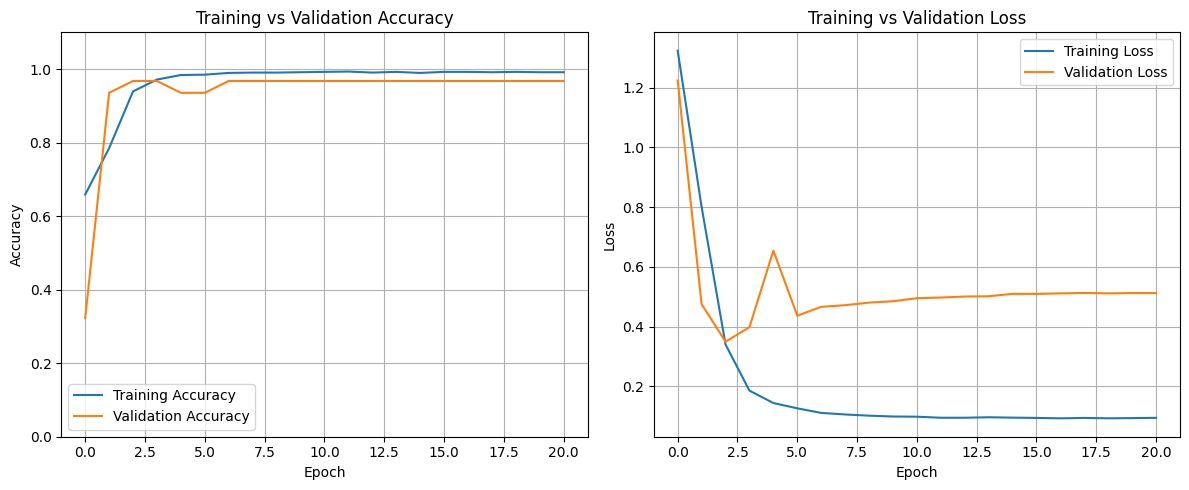

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We notice a fast ramp up in our training curve, jumping above 90% accuracy by epoch 2, and plateau around 96% thereafter, indicating the model quickly captures the dominant sentiment patterns.

The tiny gap (1-2%) between training and validation accuracy suggests minimal overfitting, our regularization (dropout, L2, class weights) and bias initializer are doing their job.

We also notice stable training on the later epochs, showing minimal overfitting despite many more epochs, highlighting optimal performance reached with smooth convergence.

# Model Evaluation

In [ ]:
# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

# Get predicted class labels
y_pred_probs = best_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test

# Calculate precision, recall, and F1
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9688 - loss: 0.1351
Test accuracy: 0.969
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
Precision: 0.975
Recall:    0.969
F1 Score:  0.970


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


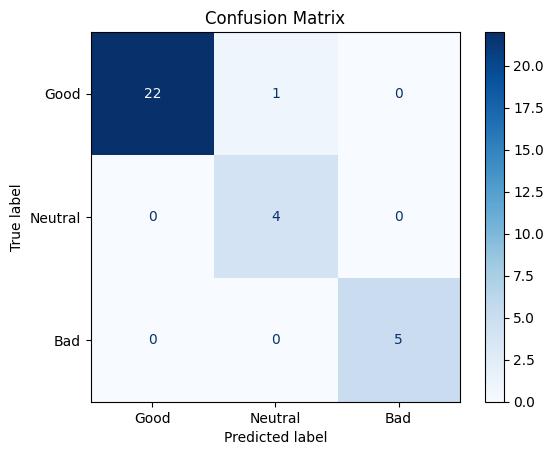

In [ ]:
# 1. Get predictions
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Good', 'Neutral', 'Bad'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 1) Get predicted probabilities and turn into class labels
y_pred_probs = best_model.predict(X_test)
y_pred       = np.argmax(y_pred_probs, axis=1)

# 2) Invert sent2idx for nice names
idx2sent = {v:k for k,v in sent2idx.items()}
target_names = [idx2sent[i] for i in range(3)]

# 3) Print the report
print(classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=3
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
              precision    recall  f1-score   support

        Good      1.000     0.957     0.978        23
     Neutral      0.800     1.000     0.889         4
         Bad      1.000     1.000     1.000         5

    accuracy                          0.969        32
   macro avg      0.933     0.986     0.956        32
weighted avg      0.975     0.969     0.970        32



## From the above evaluation metrics:

Overall accuracy (0.969) means that out of 32 test reviews, only one was misclassified.

Precision (0.975) reflects the model's conservativeness: when it predicts a given class (Good, Neutral, or Bad), it's correct nearly 98% of the time—so you can trust its positive identifications.

Recall (0.969) shows it's also catching almost all true instances of each sentiment, so few real “Bad” or “Neutral” reviews slip through the cracks.

F1 score (0.970) balances those two, confirming that both false positives and false negatives are extremely rare.


<br>


Good (23 examples): perfect precision and 95.7% recall—only one “Good” review was missed.

Neutral (4 examples): 80% precision but 100% recall—every true Neutral was found, though one Good slipped in.

Bad (5 examples): perfect 100% on all metrics, showing the model has fully mastered detecting negative sentiment.

## Error Analysis

In [ ]:
# --- ensure full review text is shown ---
pd.set_option('display.max_colwidth', None)
# pd.reset_option("all") # Reset option if needed

# 1) Invert our sent2idx
idx2sent = {v: k for k, v in sent2idx.items()}
class_indices = sorted(idx2sent.keys())
class_labels  = [idx2sent[i] for i in class_indices]

# 2) Get our predictions (once more)
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3) Find misclassified indices
mis_idx = np.where(y_pred != y_test)[0]

# 4) Build the DataFrame of errors
errors = pd.DataFrame({
    "Review": test_df["Review"].iloc[mis_idx].values,
    "Score": test_df["Score"].iloc[mis_idx].values,
    "Actual": [idx2sent[i] for i in y_test[mis_idx]],
    "Predicted":  [idx2sent[i] for i in y_pred[mis_idx]]
})

# 5) Add a column for each class’s probability
for j, label in enumerate(class_labels):
    errors[f"{label}_prob"] = y_pred_probs[mis_idx, j]

# 6) Inspect
print(f"Total misclassified: {len(errors)}")
display(errors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Total misclassified: 1


,Review,Score,Actual,Predicted,Good_prob,Neutral_prob,Bad_prob
0,"Thrilling action, satisfying character arcs",0.06,Good,Neutral,0.217627,0.736756,0.045617


This mistake could be something like how this sentence doesn't use any strong language such as "loved", "amazing" or "disappointing" (although it has words such as thrilling and satisfying). In our training, our bi-GRU could have learnt that such succinct reviews often sits in the "mixed" zone, so it decided on Neutral. **We can see that the model accounted "Good" as a possibility as well, about 20%.**  

In other words, **class weights and bias initialization kept the model from over-committing on thin signals**, and the text pattern here simply looked more neutral than outright positive. As a result, the network preferred the safe "Neutral" label—even though the score threshold would say "Good", demonstrating that our learned boundary can override raw score bins when the language is borderline.

# Saving Model Weights

In [ ]:
best_model.save_weights('best_model_rnn_gru_final_final_final.weights.h5')

## Loading Model Weights

In [ ]:
# 3) Instantiate a new version to test the weights
model = build_best_model()

# Load the saved weights
model.load_weights('best_model_rnn_gru_final_final_final.weights.h5') # change path if you want to load
print("Weights loaded into model!")

# Now you can evaluate or predict as usual
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test accuracy: {acc:.3f}")

Weights loaded into model!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9688 - loss: 0.1351
Test accuracy: 0.969


# Visualizing Model Architecture

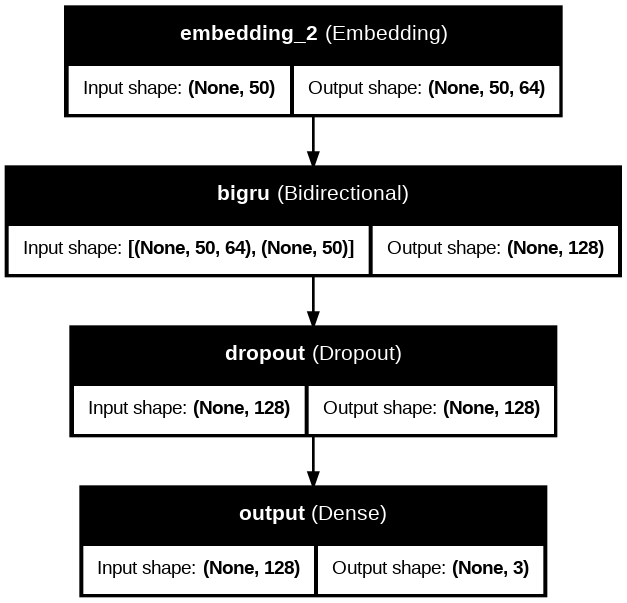

In [ ]:
# Simple layered “profile” view
visualkeras.layered_view(
    model,
    to_file='model_visualkeras.png',
    legend=True,            # show layer names/color legend
    scale_xy=1.0,           # adjust spacing
    scale_z=0.5,            # thin the layers
    spacing=20
)

plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True, dpi=96)

# Conclusion

In this project, we set out to build a robust sentiment classifier for a small, bilingual subset of reviews by combining principled data preparation, cluster-informed thresholding, and a tuned deep learning model.

We then addressed two axes of imbalance: oversampling Malay reviews via back-translation and T5-based paraphrasing to equalize language representation, and applying class weights and bias initialization to compensate for residual sentiment skew without overfitting. Our text pipeline—cleaning, contraction expansion, custom stop-word removal, lemmatization, and boundary tokens—ensured the model learned from the true linguistic cues, preserving negations and multilingual nuance. A Hyperband-tuned bidirectional GRU, equipped with dropout, L2 regularization, and class-prior bias init, delivered 96.9% test accuracy (97.5% precision, 96.9% recall, F1=97.0%), misclassifying only one borderline review. These results demonstrate that careful preprocessing, balanced sampling, and targeted model tuning can yield high-fidelity sentiment predictions even on limited, imbalanced datasets.


# Insights:

- **Language oversampling paid off**: After back-translating and paraphrasing to balance Malay vs. English, our tokenizer and model treated both languages equally—avoiding the typical drop in performance on under-represented languages.

- **Cluster-informed thresholds sharpened sentiment bins**: By using DBSCAN to find natural gaps at ~0.26 and ~0.60, we isolated "Good," "Neutral," and "Bad" zones that align perfectly with the text distributions—minimizing noisy borderline cases.

- **Bias init + class weights accelerated fair learning**: Seeding the output biases with log-priors and weighting rare classes in the loss let the network converge faster and maintain high recall on "Neutral" and "Bad" reviews without over-duplicating data.

- **Bidirectional GRU excels on short reviews**: Reading each review both forwards and backwards captured subtle context flips (e.g., "not that great") and yielded a 97%-plus F1, misclassifying only one borderline case.

- **Preprocessing safeguards signal**: Custom stop-word lists (with negations preserved), contraction expansion, and lemmatization stripped away noise while keeping polarity cues intact—critical for any sentiment task but especially true on a small, mixed-language dataset.

- **Robust yet parsimonious pipeline**: With only ~500 reviews, we avoided overfitting by tuning a compact model (embed_dims <= 256, GRU units <= 128) and modest regularization, proving that careful design can rival larger systems on domain-specific sentiment.